**1**

In [ ]:
# Import all necessary libraries for water quality forecasting evaluation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score,
    mean_absolute_percentage_error
)
from sklearn.model_selection import TimeSeriesSplit
import joblib
import os
from datetime import datetime, timedelta
import firebase_admin
from firebase_admin import credentials, db
import warnings
warnings.filterwarnings('ignore')

# Import TensorFlow for LSTM model
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import math

print("All packages imported successfully!")
print(f"TensorFlow version: {tf.__version__}")

All packages imported successfully!
TensorFlow version: 2.18.0


**2**

In [ ]:
# Initialize Firebase app (upload your Firebase credentials JSON file to Colab)
cred = credentials.Certificate("/content/drive/MyDrive/Firebase-Credentials/waterqualitymonitoring-10336-firebase-adminsdk-aj5im-2ef10d4277.json")
firebase_admin.initialize_app(cred, {
    'databaseURL': 'https://waterqualitymonitoring-10336-default-rtdb.asia-southeast1.firebasedatabase.app/'
})

**3**

In [ ]:
def fetch_sensor_data():
    """Fetch sensor data from Firebase Realtime Database"""
    try:
        ref = db.reference('sensor_data')
        data = ref.get()
        if not data:
            return pd.DataFrame()

        records = []
        for key, value in data.items():
            try:
                value['timestamp'] = datetime.strptime(value['timestamp'], '%Y-%m-%d %H:%M:%S')
                records.append(value)
            except (ValueError, KeyError) as e:
                print(f"Skipping invalid record {key}: {e}")
                continue

        df = pd.DataFrame(records)
        if not df.empty:
            df = df.sort_values('timestamp')
            required_features = ['ph', 'turbidity', 'tds', 'temperature', 'conductivity']
            df = df[['timestamp'] + required_features].dropna()

            # Outlier removal using IQR
            for feature in required_features:
                Q1 = df[feature].quantile(0.25)
                Q3 = df[feature].quantile(0.75)
                IQR = Q3 - Q1
                lower_bound = Q1 - 1.5 * IQR
                upper_bound = Q3 + 1.5 * IQR
                df = df[(df[feature] >= lower_bound) & (df[feature] <= upper_bound)]

        return df
    except Exception as e:
        print(f"Error fetching sensor data: {e}")
        return pd.DataFrame()

def create_forecasting_sequences(data, seq_length=20, forecast_horizon=1):
    """Create sequences for time series forecasting"""
    features = ['ph', 'turbidity', 'tds', 'temperature', 'conductivity']
    data = data.sort_values('timestamp')
    feature_data = data[features].values

    X, y = [], []
    for i in range(len(feature_data) - seq_length - forecast_horizon + 1):
        X.append(feature_data[i:(i + seq_length)])
        if forecast_horizon == 1:
            y.append(feature_data[i + seq_length])
        else:
            y.append(feature_data[i + seq_length:i + seq_length + forecast_horizon])

    return np.array(X), np.array(y)

def add_noise_for_robustness(data, noise_factor=0.005):
    """Add small amount of noise to make model more robust"""
    noisy_data = data.copy()
    features = ['ph', 'turbidity', 'tds', 'temperature', 'conductivity']

    for feature in features:
        noise = np.random.normal(0, noise_factor * np.std(noisy_data[feature]), len(noisy_data))
        noisy_data[feature] = noisy_data[feature] + noise

    return noisy_data

print("Data loading and preprocessing functions defined successfully!")

Data loading and preprocessing functions defined successfully!


**4**

In [ ]:
# Load water quality data from Firebase
print("Loading water quality data from Firebase...")
water_quality_df = fetch_sensor_data()

print(f"Water quality samples loaded: {len(water_quality_df)}")
if not water_quality_df.empty:
    print(f"Data date range: {water_quality_df['timestamp'].min()} to {water_quality_df['timestamp'].max()}")
    print("\nWater quality data sample:")
    print(water_quality_df.head())
    print("\nWater quality data statistics:")
    features = ['ph', 'turbidity', 'tds', 'temperature', 'conductivity']
    print(water_quality_df[features].describe())

    # Check for missing values
    print("\nMissing values:")
    print(water_quality_df[features].isnull().sum())

    # Check data quality
    print("\nData quality checks:")
    for feature in features:
        outliers = water_quality_df[feature].quantile(0.99) - water_quality_df[feature].quantile(0.01)
        print(f"{feature}: Range = {water_quality_df[feature].min():.2f} - {water_quality_df[feature].max():.2f}, IQR = {outliers:.2f}")

    # Add some noise for robustness testing
    print("\nAdding noise for robustness testing...")
    enhanced_df = add_noise_for_robustness(water_quality_df, noise_factor=0.02)

    # Combine original and noisy data
    combined_df = pd.concat([water_quality_df, enhanced_df], ignore_index=True)
    combined_df = combined_df.sort_values('timestamp')

    print(f"Enhanced dataset size: {len(combined_df)} samples")
    print(f"Time span: {(combined_df['timestamp'].max() - combined_df['timestamp'].min()).days} days")

else:
    print("Error: No data available for training!")

Loading water quality data from Firebase...
Water quality samples loaded: 16601
Data date range: 2024-11-02 09:33:00 to 2025-04-26 19:04:51

Water quality data sample:
                timestamp       ph  turbidity        tds  temperature  \
8473  2024-11-02 09:33:00  6.97361    1.70666  142.73901       6.7798   
7849  2024-11-02 09:33:22  6.99664    2.03304  107.41648       7.4540   
10377 2024-11-02 09:33:44  7.05138    1.42057  165.08363       7.2506   
9574  2024-11-02 09:41:03  7.05983    1.47834  122.88723       7.2870   
4631  2024-11-02 09:41:21  7.11011    1.54506  129.19632       7.3087   

       conductivity  
8473      289.82853  
7849      235.89012  
10377     324.99847  
9574      262.77725  
4631      259.67076  

Water quality data statistics:
                ph     turbidity           tds   temperature  conductivity
count  16601.00000  16601.000000  16601.000000  16601.000000  16601.000000
mean       7.28974      1.624062    150.273979      9.617728    309.541248
std 

**5**

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, Attention, Input
from sklearn.preprocessing import StandardScaler
import numpy as np

class EnhancedWaterQualityLSTM:
    def __init__(self, sequence_length=15, forecast_horizon=1):
        self.model = None
        self.scalers = {}  # Store scalers for each feature
        self.sequence_length = sequence_length
        self.forecast_horizon = forecast_horizon
        self.feature_names = ['ph', 'turbidity', 'tds', 'temperature', 'conductivity']

    def create_sequences(self, data, seq_length):
        """Create sequences for LSTM training"""
        X, y = [], []
        for i in range(len(data) - seq_length):
            X.append(data[i:(i + seq_length)])
            y.append(data[i + seq_length])
        return np.array(X), np.array(y)

    def build_model(self, seq_length, n_features):
        """Build enhanced LSTM model with weighted loss"""
        inputs = Input(shape=(seq_length, n_features))

        x = Bidirectional(
            LSTM(64, activation='relu', return_sequences=True)
        )(inputs)
        x = Dropout(0.2)(x)

        attention_output = Attention()([x, x])

        x = LSTM(32, activation='relu', return_sequences=False)(attention_output)
        x = Dropout(0.2)(x)

        x = Dense(16, activation='relu',
                  kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
        outputs = Dense(n_features)(x)

        model = Model(inputs=inputs, outputs=outputs)

        def weighted_mse(y_true, y_pred):
            weights = tf.constant([1.0, 1.0, 0.1, 1.0, 0.05], dtype=tf.float32)
            return tf.reduce_mean(tf.square(y_true - y_pred) * weights)

        optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, clipnorm=1.0)
        model.compile(
            optimizer=optimizer,
            loss=weighted_mse,
            metrics=['mae', 'mse']
        )
        return model

    def prepare_data(self, df):
        """Prepare data with feature-specific scaling"""
        scaled_data = np.zeros_like(df[self.feature_names])
        for i, feature in enumerate(self.feature_names):
            scaler = StandardScaler()
            scaled_data[:, i] = scaler.fit_transform(df[[feature]].values)[:, 0]
            self.scalers[feature] = scaler  # Store scaler for each feature
        X, y = self.create_sequences(scaled_data, self.sequence_length)

        print(f"Created {len(X)} sequences of length {self.sequence_length}")
        print(f"Input shape: {X.shape}, Output shape: {y.shape}")

        return X, y

    def train(self, df, epochs=50, batch_size=32, validation_split=0.2):
        """Train the model"""
        X, y = self.prepare_data(df)

        self.model = self.build_model(self.sequence_length, len(self.feature_names))

        callbacks = [
            tf.keras.callbacks.EarlyStopping(patience=15, restore_best_weights=True),
            tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5),
            tf.keras.callbacks.ModelCheckpoint('best_model.keras', save_best_only=True)
        ]

        history = self.model.fit(
            X, y,
            epochs=epochs,
            batch_size=batch_size,
            validation_split=validation_split,
            verbose=1,
            callbacks=callbacks
        )

        return history, X, y

    def predict_sequence(self, last_sequence, n_steps):
        """Predict next n steps"""
        scaled_sequence = np.zeros_like(last_sequence)
        for i, feature in enumerate(self.feature_names):
            scaled_sequence[:, i] = self.scalers[feature].transform(last_sequence[[feature]].values)[:, 0]
        predictions = []
        current_sequence = scaled_sequence.copy()

        for _ in range(n_steps):
            scaled_prediction = self.model.predict(current_sequence.reshape(1, *current_sequence.shape), verbose=0)
            predictions.append(scaled_prediction[0])
            current_sequence = np.roll(current_sequence, -1, axis=0)
            current_sequence[-1] = scaled_prediction[0]

        predictions = np.array(predictions)
        for i, feature in enumerate(self.feature_names):
            predictions[:, i] = self.scalers[feature].inverse_transform(predictions[:, [i]])[:, 0]
        return predictions

print("Enhanced Water Quality LSTM class defined successfully!")

Enhanced Water Quality LSTM class defined successfully!


**6**

In [ ]:
# Initialize the enhanced water quality predictor
sequence_length = 15
forecast_horizon = 1
predictor = EnhancedWaterQualityLSTM(sequence_length=sequence_length, forecast_horizon=forecast_horizon)

print("Training Water Quality LSTM Model...")
try:
    # Train the model
    history, X_full, y_full = predictor.train(
        combined_df,
        epochs=50,
        batch_size=32,
        validation_split=0.2
    )

    print("Model training completed!")
    print("\nModel architecture:")
    predictor.model.summary()

    # Prepare test data (use temporal split for realistic evaluation)
    split_idx = int(0.8 * len(X_full))
    X_train, X_test = X_full[:split_idx], X_full[split_idx:]
    y_train, y_test = y_full[:split_idx], y_full[split_idx:]

    print(f"\nData split:")
    print(f"Training sequences: {len(X_train)}")
    print(f"Test sequences: {len(X_test)}")

    # Make predictions on test set
    print("\nMaking predictions on test set...")
    y_pred = predictor.model.predict(X_test, verbose=0)

    # Inverse transform for evaluation
    y_test_original = np.zeros_like(y_test)
    y_pred_original = np.zeros_like(y_pred)
    for i, feature in enumerate(predictor.feature_names):
        y_test_original[:, i] = StandardScaler().fit(combined_df[[feature]].values).inverse_transform(y_test[:, [i]])[:, 0]
        y_pred_original[:, i] = StandardScaler().fit(combined_df[[feature]].values).inverse_transform(y_pred[:, [i]])[:, 0]

    print("Predictions completed!")

except Exception as e:
    print(f"Error during training or prediction: {e}")
    raise

Training Water Quality LSTM Model...
Created 33187 sequences of length 15
Input shape: (33187, 15, 5), Output shape: (33187, 5)
Epoch 1/50
830/830 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - loss: 0.3854 - mae: 0.5764 - mse: 0.5810 - val_loss: 0.6375 - val_mae: 0.6188 - val_mse: 0.8565 - learning_rate: 0.0010
Epoch 2/50
830/830 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.1878 - mae: 0.4155 - mse: 0.3319 - val_loss: 0.9625 - val_mae: 0.5916 - val_mse: 1.1332 - learning_rate: 0.0010
Epoch 3/50
830/830 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.1506 - mae: 0.3794 - mse: 0.2852 - val_loss: 0.2158 - val_mae: 0.4357 - val_mse: 0.3370 - learning_rate: 0.0010
Epoch 4/50
830/830 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.1389 - mae: 0.3606 - mse: 0.2650 - val_loss: 0.2405 - val_mae: 0.4757 - val_mse: 0.4160 - learning_rate: 0.0010
Epoch 5/50
830/830 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.1332 - mae: 0.3511 - mse: 0.2541 - val_loss: 0.2103 - val_mae: 0.4241 - val_mse: 0.3298 - learning_rate: 0.0010


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 15, 5)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_2     │ (None, 15, 128)   │     35,840 │ input_layer_2[0]… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 15, 128)   │          0 │ bidirectional_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_2         │ (None, 15, 128)   │          0 │ dropout_4[0][0],  │
│ (Attention)         │                   │            │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_5 (LSTM)       │ (None, 32)        │     20,608 │ attention_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 32)        │          0 │ lstm_5[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 16)        │        528 │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 5)         │         85 │ dense_4[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 171,185 (668.70 KB)

 Trainable params: 57,061 (222.89 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 114,124 (445.80 KB)


Data split:
Training sequences: 26549
Test sequences: 6638

Making predictions on test set...
Predictions completed!


**7**

=== WATER QUALITY FORECASTING MODEL PERFORMANCE ===
Test samples: 6638
Forecast horizon: 1 timestep(s)
Sequence length: 15 timesteps

=== OVERALL PERFORMANCE METRICS ===
Mean Absolute Error (MAE): 5.5355
Mean Squared Error (MSE): 122.5505
Root Mean Squared Error (RMSE): 11.0703
R² Score: 0.5962
Mean Absolute Percentage Error (MAPE): 5.25%

=== FEATURE-WISE PERFORMANCE ===

pH:
  MAE: 0.0817
  RMSE: 0.1087
  R²: 0.7622
  MAPE: 1.11%

Turbidity:
  MAE: 0.1187
  RMSE: 0.1717
  R²: 0.6245
  MAPE: 7.23%

TDS:
  MAE: 9.6277
  RMSE: 12.1930
  R²: 0.5860
  MAPE: 6.21%

Temperature:
  MAE: 0.9234
  RMSE: 1.3635
  R²: 0.3524
  MAPE: 6.44%

Conductivity:
  MAE: 16.9259
  RMSE: 21.4984
  R²: 0.6558
  MAPE: 5.26%

=== TIME SERIES CROSS-VALIDATION ===
CV MAE: 6.9637 (+/- 4.1100)
CV RMSE: 14.3466 (+/- 8.2520)
CV R²: 0.5501 (+/- 0.1886)

=== TRAINING HISTORY ANALYSIS ===
Final Training MAE: 0.2949
Final Validation MAE: 0.4597
Final Training Loss: 0.1048
Final Validation Loss: 0.2568

=== MODEL PERFORM

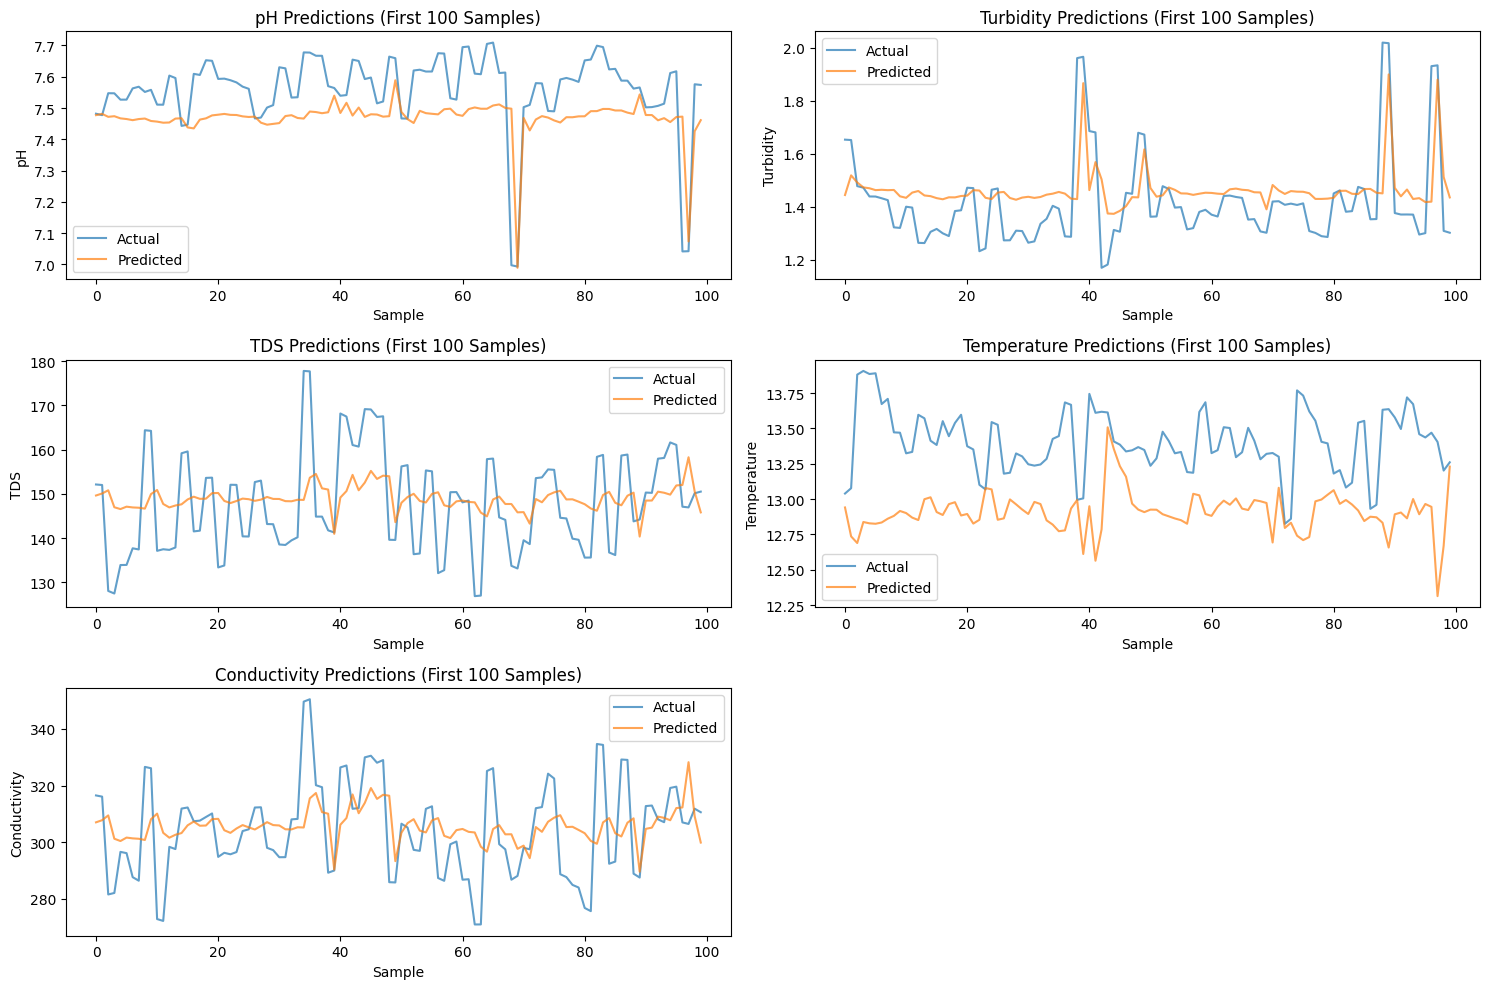


=== RESIDUAL ANALYSIS ===


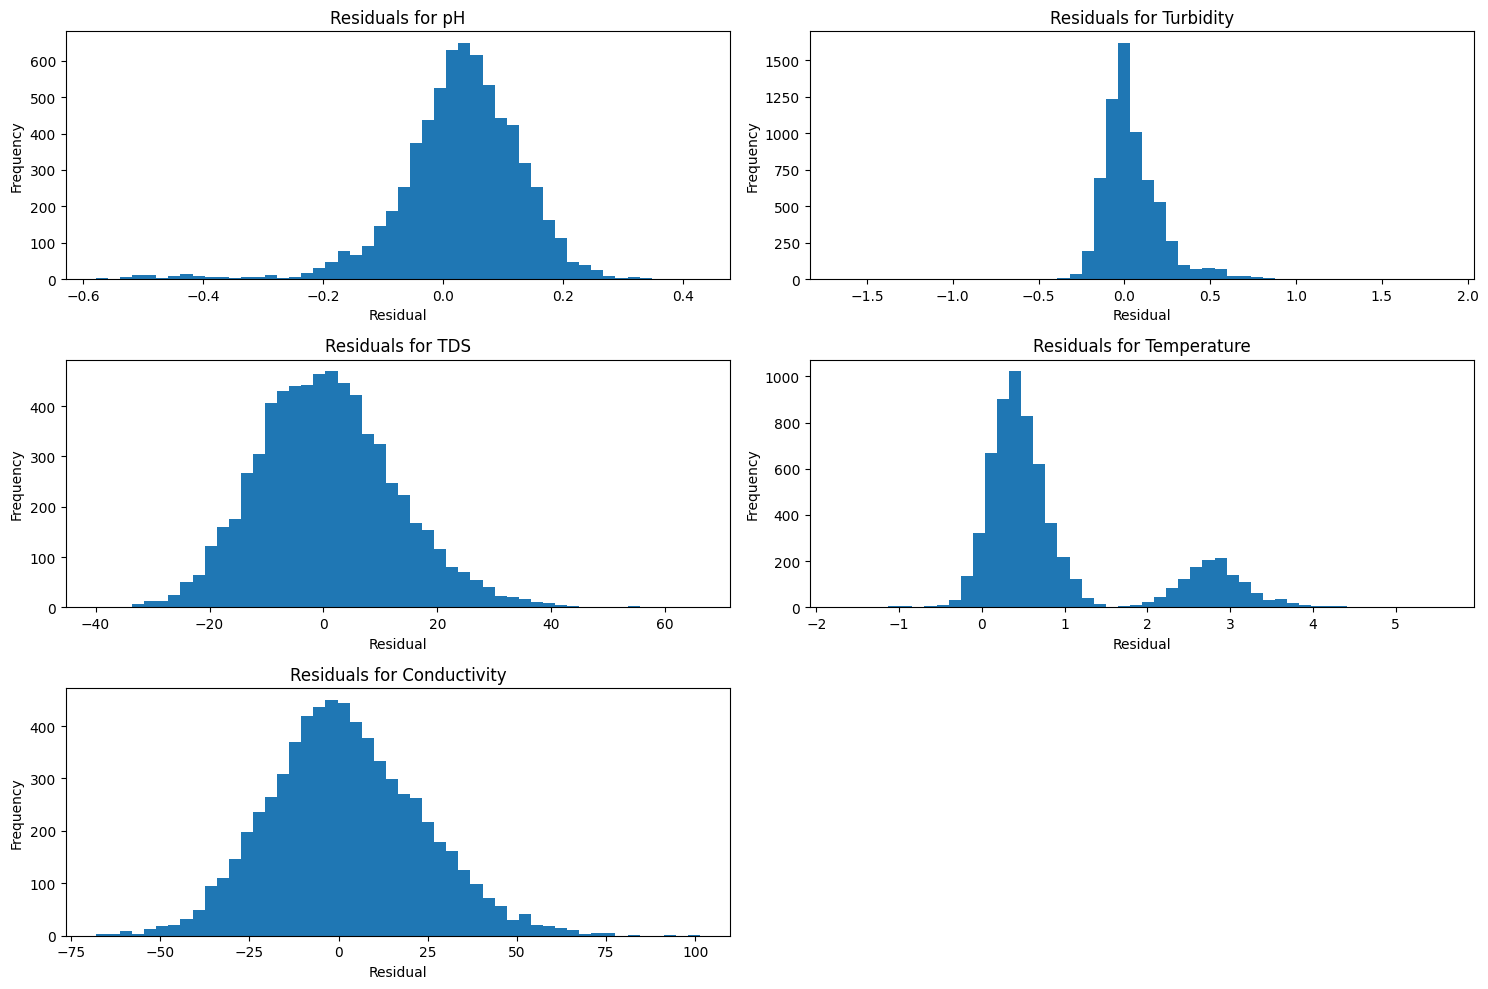

In [ ]:
# Calculate comprehensive regression metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit

feature_names = ['pH', 'Turbidity', 'TDS', 'Temperature', 'Conductivity']

print("=== WATER QUALITY FORECASTING MODEL PERFORMANCE ===")
print(f"Test samples: {len(y_test_original)}")
print(f"Forecast horizon: {forecast_horizon} timestep(s)")
print(f"Sequence length: {sequence_length} timesteps")

# Overall metrics
overall_mae = mean_absolute_error(y_test_original, y_pred_original)
overall_mse = mean_squared_error(y_test_original, y_pred_original)
overall_rmse = np.sqrt(overall_mse)
overall_r2 = r2_score(y_test_original, y_pred_original)

def safe_mape(y_true, y_pred):
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

overall_mape = safe_mape(y_test_original, y_pred_original)

print(f"\n=== OVERALL PERFORMANCE METRICS ===")
print(f"Mean Absolute Error (MAE): {overall_mae:.4f}")
print(f"Mean Squared Error (MSE): {overall_mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {overall_rmse:.4f}")
print(f"R² Score: {overall_r2:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {overall_mape:.2f}%")

# Feature-wise performance
print(f"\n=== FEATURE-WISE PERFORMANCE ===")
feature_metrics = []

for i, feature_name in enumerate(feature_names):
    y_true_feature = y_test_original[:, i]
    y_pred_feature = y_pred_original[:, i]

    mae = mean_absolute_error(y_true_feature, y_pred_feature)
    mse = mean_squared_error(y_true_feature, y_pred_feature)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true_feature, y_pred_feature)
    mape = safe_mape(y_true_feature, y_pred_feature)

    print(f"\n{feature_name}:")
    print(f"  MAE: {mae:.4f}")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  R²: {r2:.4f}")
    print(f"  MAPE: {mape:.2f}%")

    feature_metrics.append({
        'Feature': feature_name,
        'MAE': mae,
        'RMSE': rmse,
        'R²': r2,
        'MAPE': mape
    })

# Time series cross-validation
print(f"\n=== TIME SERIES CROSS-VALIDATION ===")
tscv = TimeSeriesSplit(n_splits=5)
cv_scores = {'mae': [], 'rmse': [], 'r2': []}

for train_idx, val_idx in tscv.split(X_train):
    X_cv_train, X_cv_val = X_train[train_idx], X_train[val_idx]
    y_cv_train, y_cv_val = y_train[train_idx], y_train[val_idx]

    # Get the original training data for this fold
    train_df = combined_df.iloc[train_idx].sort_values('timestamp')

    # Fit scalers and create sequences consistently with prepare_data
    scalers = {}
    scaled_data = np.zeros_like(train_df[predictor.feature_names])
    for i, feature in enumerate(predictor.feature_names):
        scalers[feature] = StandardScaler()
        scaled_data[:, i] = scalers[feature].fit_transform(train_df[[feature]].values)[:, 0]

    # Create sequences using the same logic as create_sequences
    X_cv_train_orig, y_cv_train_orig = predictor.create_sequences(scaled_data, predictor.sequence_length)

    # Build and train temporary model
    temp_model = predictor.build_model(predictor.sequence_length, len(feature_names))
    temp_model.fit(X_cv_train_orig, y_cv_train_orig, epochs=20, batch_size=32, verbose=0)

    # Predict and evaluate
    y_cv_pred = temp_model.predict(X_cv_val, verbose=0)

    # Transform back to original scale
    y_cv_val_orig = np.zeros_like(y_cv_val)
    y_cv_pred_orig = np.zeros_like(y_cv_pred)
    for i, feature in enumerate(predictor.feature_names):
        y_cv_val_orig[:, i] = scalers[feature].inverse_transform(y_cv_val[:, [i]])[:, 0]
        y_cv_pred_orig[:, i] = scalers[feature].inverse_transform(y_cv_pred[:, [i]])[:, 0]

    cv_mae = mean_absolute_error(y_cv_val_orig, y_cv_pred_orig)
    cv_rmse = np.sqrt(mean_squared_error(y_cv_val_orig, y_cv_pred_orig))
    cv_r2 = r2_score(y_cv_val_orig, y_cv_pred_orig)

    cv_scores['mae'].append(cv_mae)
    cv_scores['rmse'].append(cv_rmse)
    cv_scores['r2'].append(cv_r2)

cv_mae_mean = np.mean(cv_scores['mae'])
cv_rmse_mean = np.mean(cv_scores['rmse'])
cv_r2_mean = np.mean(cv_scores['r2'])

print(f"CV MAE: {cv_mae_mean:.4f} (+/- {np.std(cv_scores['mae']) * 2:.4f})")
print(f"CV RMSE: {cv_rmse_mean:.4f} (+/- {np.std(cv_scores['rmse']) * 2:.4f})")
print(f"CV R²: {cv_r2_mean:.4f} (+/- {np.std(cv_scores['r2']) * 2:.4f})")

# Training history analysis
print(f"\n=== TRAINING HISTORY ANALYSIS ===")
final_train_mae = history.history['mae'][-1]
final_val_mae = history.history['val_mae'][-1]
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]

print(f"Final Training MAE: {final_train_mae:.4f}")
print(f"Final Validation MAE: {final_val_mae:.4f}")
print(f"Final Training Loss: {final_train_loss:.4f}")
print(f"Final Validation Loss: {final_val_loss:.4f}")

# Model performance interpretation
print(f"\n=== MODEL PERFORMANCE INTERPRETATION ===")
if overall_r2 > 0.9:
    performance = "Excellent"
elif overall_r2 > 0.8:
    performance = "Good"
elif overall_r2 > 0.7:
    performance = "Fair"
else:
    performance = "Poor"

print(f"Overall Model Performance: {performance} (R² = {overall_r2:.4f})")

# Create metrics summary for research paper
metrics_summary = pd.DataFrame({
    'Metric': ['MAE', 'RMSE', 'R²', 'MAPE (%)', 'CV MAE', 'CV RMSE', 'CV R²'],
    'Value': [overall_mae, overall_rmse, overall_r2, overall_mape,
              cv_mae_mean, cv_rmse_mean, cv_r2_mean]
})
metrics_summary['Value'] = metrics_summary['Value'].round(4)

print(f"\n=== METRICS SUMMARY TABLE FOR RESEARCH PAPER ===")
print(metrics_summary.to_string(index=False))

# Feature-wise metrics table
feature_metrics_df = pd.DataFrame(feature_metrics)
print(f"\n=== FEATURE-WISE METRICS TABLE ===")
print(feature_metrics_df.round(4).to_string(index=False))

# Actual vs. Predicted Plots
plt.figure(figsize=(15, 10))
for i, feature_name in enumerate(feature_names):
    plt.subplot(3, 2, i+1)
    plt.plot(y_test_original[:, i][:100], label='Actual', alpha=0.7)
    plt.plot(y_pred_original[:, i][:100], label='Predicted', alpha=0.7)
    plt.title(f"{feature_name} Predictions (First 100 Samples)")
    plt.xlabel("Sample")
    plt.ylabel(feature_name)
    plt.legend()
plt.tight_layout()
plt.show()

# Residual Analysis Plot
print(f"\n=== RESIDUAL ANALYSIS ===")
plt.figure(figsize=(15, 10))
for i, feature_name in enumerate(feature_names):
    residuals = y_test_original[:, i] - y_pred_original[:, i]
    plt.subplot(3, 2, i+1)
    plt.hist(residuals, bins=50)
    plt.title(f"Residuals for {feature_name}")
    plt.xlabel("Residual")
    plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

**8**

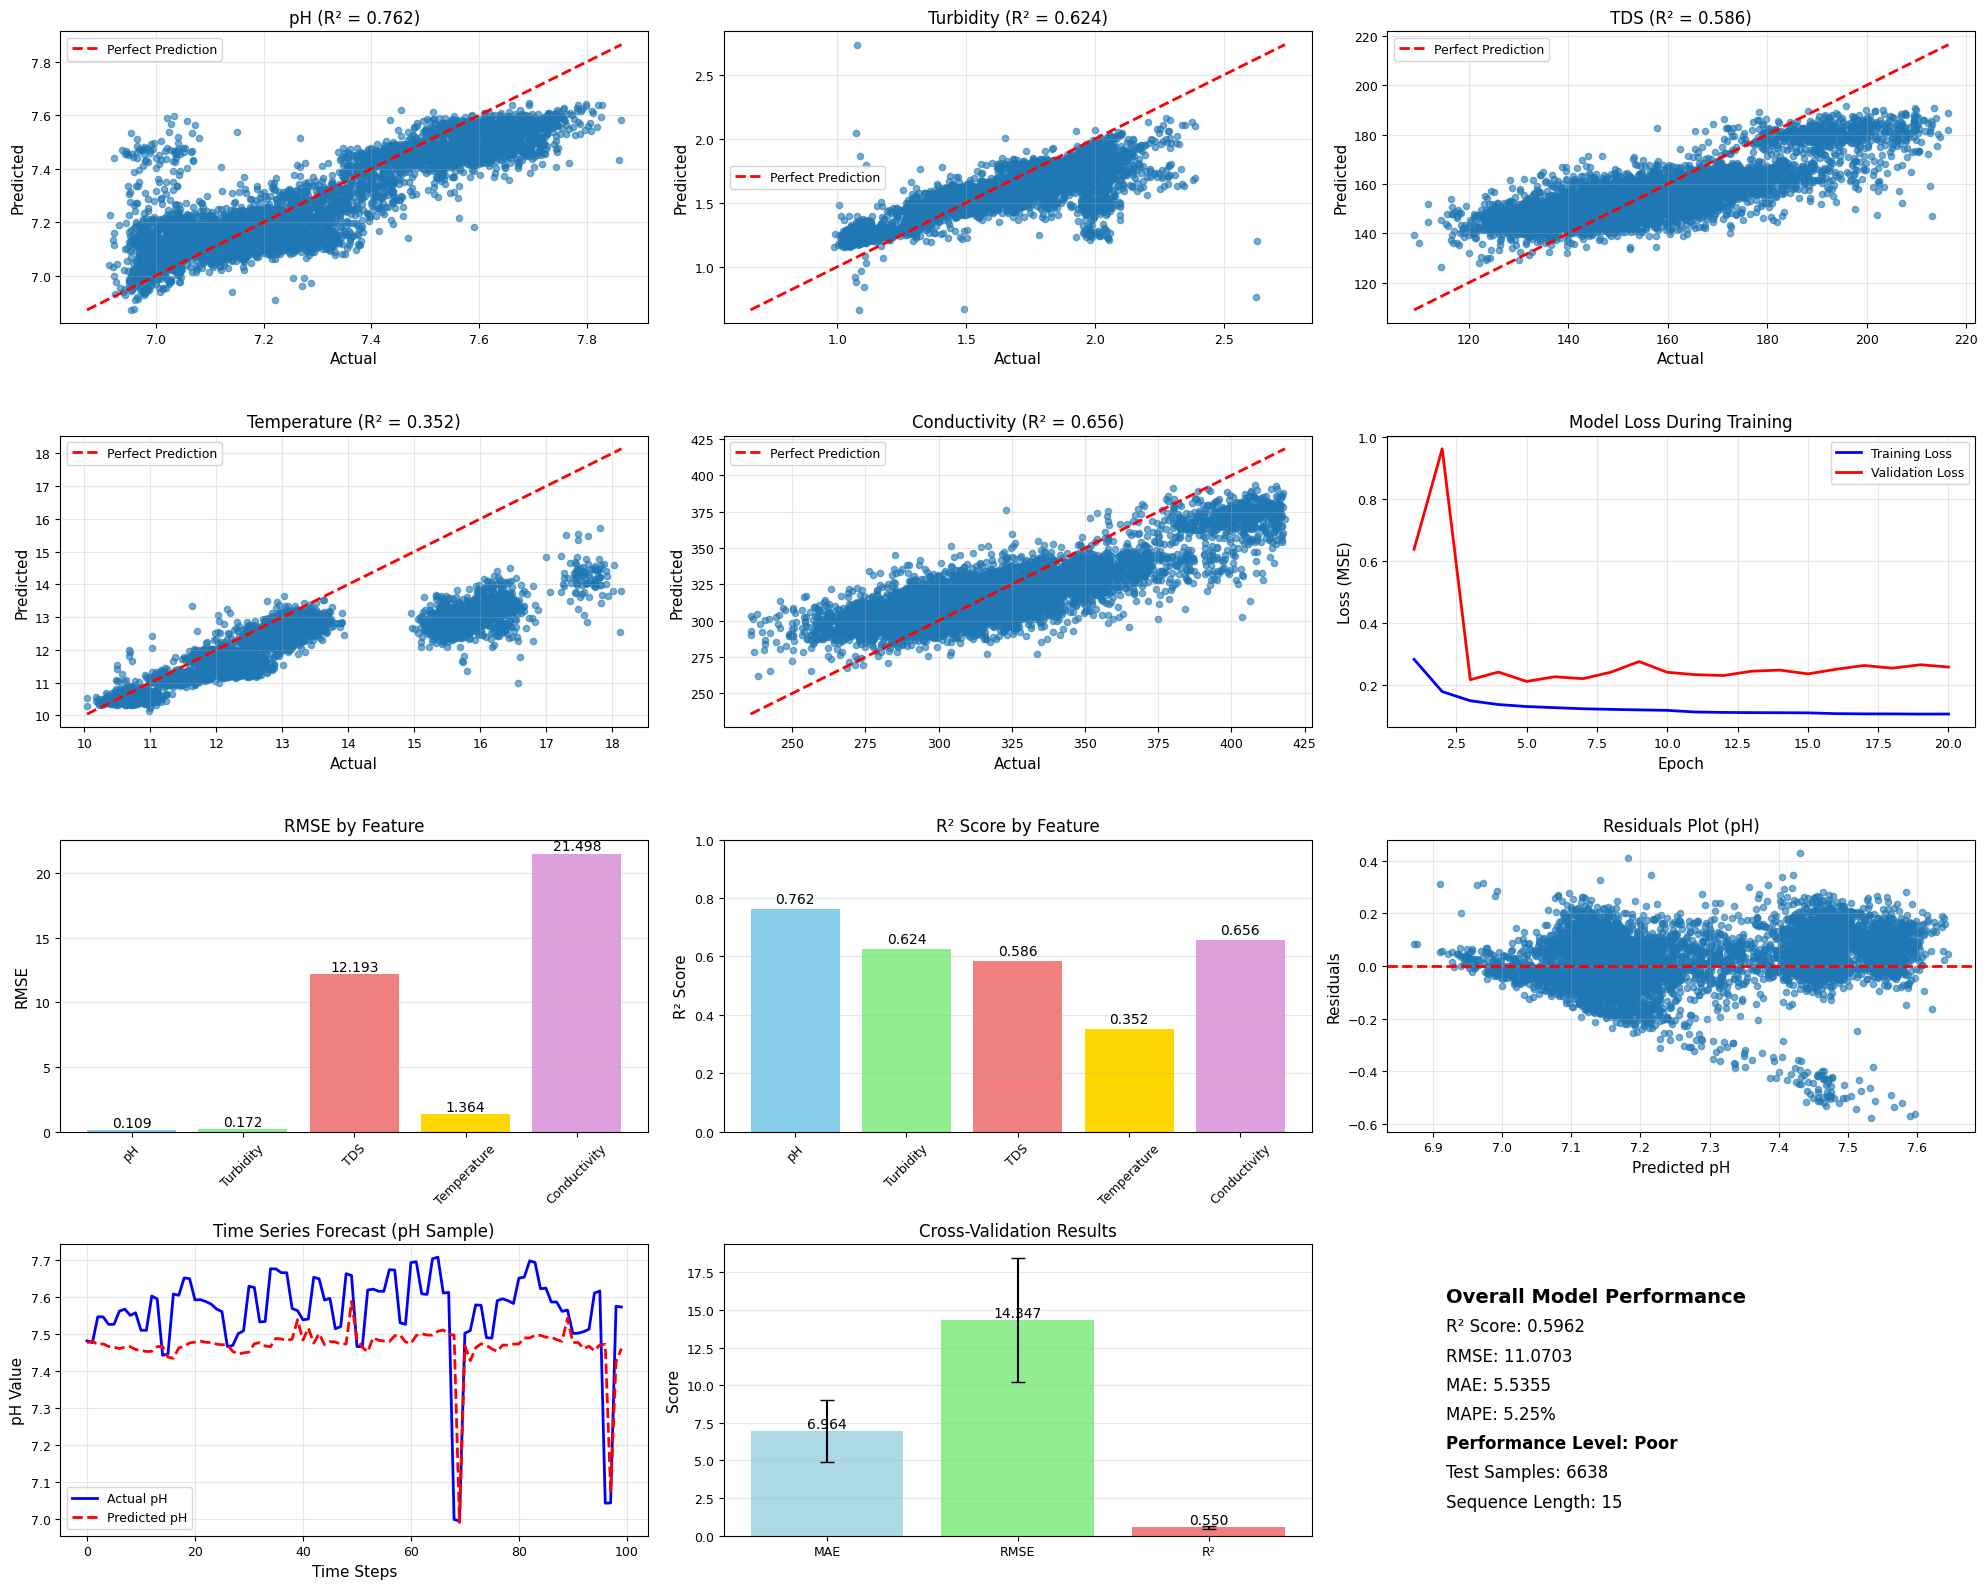

Comprehensive evaluation plots saved as 'water_quality_lstm_evaluation_plots.png'


In [ ]:
# Set up plotting parameters for publication quality
plt.style.use('default')
plt.rcParams['figure.figsize'] = (16, 12)
plt.rcParams['font.size'] = 10
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['axes.labelsize'] = 11
plt.rcParams['xtick.labelsize'] = 9
plt.rcParams['ytick.labelsize'] = 9
plt.rcParams['legend.fontsize'] = 9

# Create comprehensive evaluation plots
fig = plt.figure(figsize=(20, 16))

# 1. Feature-wise Actual vs Predicted plots
for i, feature_name in enumerate(feature_names):
    plt.subplot(4, 3, i+1)
    y_true_feature = y_test_original[:, i]
    y_pred_feature = y_pred_original[:, i]

    plt.scatter(y_true_feature, y_pred_feature, alpha=0.6, s=20)

    # Perfect prediction line
    min_val = min(y_true_feature.min(), y_pred_feature.min())
    max_val = max(y_true_feature.max(), y_pred_feature.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')

    # Calculate R²
    r2 = r2_score(y_true_feature, y_pred_feature)
    plt.title(f'{feature_name} (R² = {r2:.3f})')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.legend()
    plt.grid(True, alpha=0.3)

# 6. Training History
plt.subplot(4, 3, 6)
epochs = range(1, len(history.history['loss']) + 1)
plt.plot(epochs, history.history['loss'], 'b-', label='Training Loss', linewidth=2)
plt.plot(epochs, history.history['val_loss'], 'r-', label='Validation Loss', linewidth=2)
plt.title('Model Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True, alpha=0.3)

# 7. Feature-wise RMSE comparison
plt.subplot(4, 3, 7)
feature_rmse = [metric['RMSE'] for metric in feature_metrics]
bars = plt.bar(feature_names, feature_rmse, color=['skyblue', 'lightgreen', 'lightcoral', 'gold', 'plum'])
plt.title('RMSE by Feature')
plt.ylabel('RMSE')
plt.xticks(rotation=45)
for bar, rmse in zip(bars, feature_rmse):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{rmse:.3f}', ha='center', va='bottom')
plt.grid(True, alpha=0.3, axis='y')

# 8. R² Score by Feature
plt.subplot(4, 3, 8)
feature_r2 = [metric['R²'] for metric in feature_metrics]
bars = plt.bar(feature_names, feature_r2, color=['skyblue', 'lightgreen', 'lightcoral', 'gold', 'plum'])
plt.title('R² Score by Feature')
plt.ylabel('R² Score')
plt.xticks(rotation=45)
plt.ylim(0, 1)
for bar, r2 in zip(bars, feature_r2):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{r2:.3f}', ha='center', va='bottom')
plt.grid(True, alpha=0.3, axis='y')

# 9. Residuals plot for pH (most important feature)
plt.subplot(4, 3, 9)
ph_residuals = y_test_original[:, 0] - y_pred_original[:, 0]
plt.scatter(y_pred_original[:, 0], ph_residuals, alpha=0.6, s=20)
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
plt.title('Residuals Plot (pH)')
plt.xlabel('Predicted pH')
plt.ylabel('Residuals')
plt.grid(True, alpha=0.3)

# 10. Time series plot (sample)
plt.subplot(4, 3, 10)
sample_length = min(100, len(y_test_original))
time_steps = range(sample_length)
plt.plot(time_steps, y_test_original[:sample_length, 0], 'b-', label='Actual pH', linewidth=2)
plt.plot(time_steps, y_pred_original[:sample_length, 0], 'r--', label='Predicted pH', linewidth=2)
plt.title('Time Series Forecast (pH Sample)')
plt.xlabel('Time Steps')
plt.ylabel('pH Value')
plt.legend()
plt.grid(True, alpha=0.3)

# 11. Cross-validation results
plt.subplot(4, 3, 11)
cv_metrics = ['MAE', 'RMSE', 'R²']
cv_values = [cv_mae_mean, cv_rmse_mean, cv_r2_mean]
cv_errors = [np.std(cv_scores['mae']), np.std(cv_scores['rmse']), np.std(cv_scores['r2'])]

bars = plt.bar(cv_metrics, cv_values, yerr=cv_errors, capsize=5,
               color=['lightblue', 'lightgreen', 'lightcoral'])
plt.title('Cross-Validation Results')
plt.ylabel('Score')
for bar, value in zip(bars, cv_values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{value:.3f}', ha='center', va='bottom')
plt.grid(True, alpha=0.3, axis='y')

# 12. Model Performance Summary
plt.subplot(4, 3, 12)
plt.text(0.1, 0.8, f'Overall Model Performance', fontsize=14, fontweight='bold')
plt.text(0.1, 0.7, f'R² Score: {overall_r2:.4f}', fontsize=12)
plt.text(0.1, 0.6, f'RMSE: {overall_rmse:.4f}', fontsize=12)
plt.text(0.1, 0.5, f'MAE: {overall_mae:.4f}', fontsize=12)
plt.text(0.1, 0.4, f'MAPE: {overall_mape:.2f}%', fontsize=12)
plt.text(0.1, 0.3, f'Performance Level: {performance}', fontsize=12, fontweight='bold')
plt.text(0.1, 0.2, f'Test Samples: {len(y_test_original)}', fontsize=12)
plt.text(0.1, 0.1, f'Sequence Length: {sequence_length}', fontsize=12)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.axis('off')

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/water_quality_lstm_evaluation_plots.png',
            dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print("Comprehensive evaluation plots saved as 'water_quality_lstm_evaluation_plots.png'")

**9**

<Figure size 1200x800 with 0 Axes>

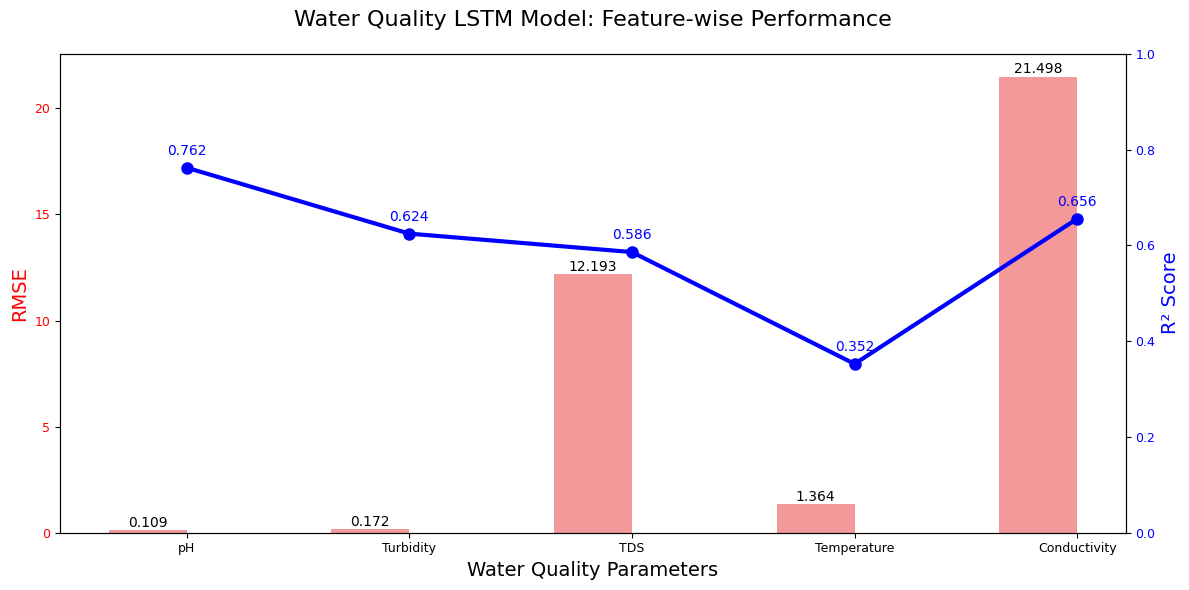

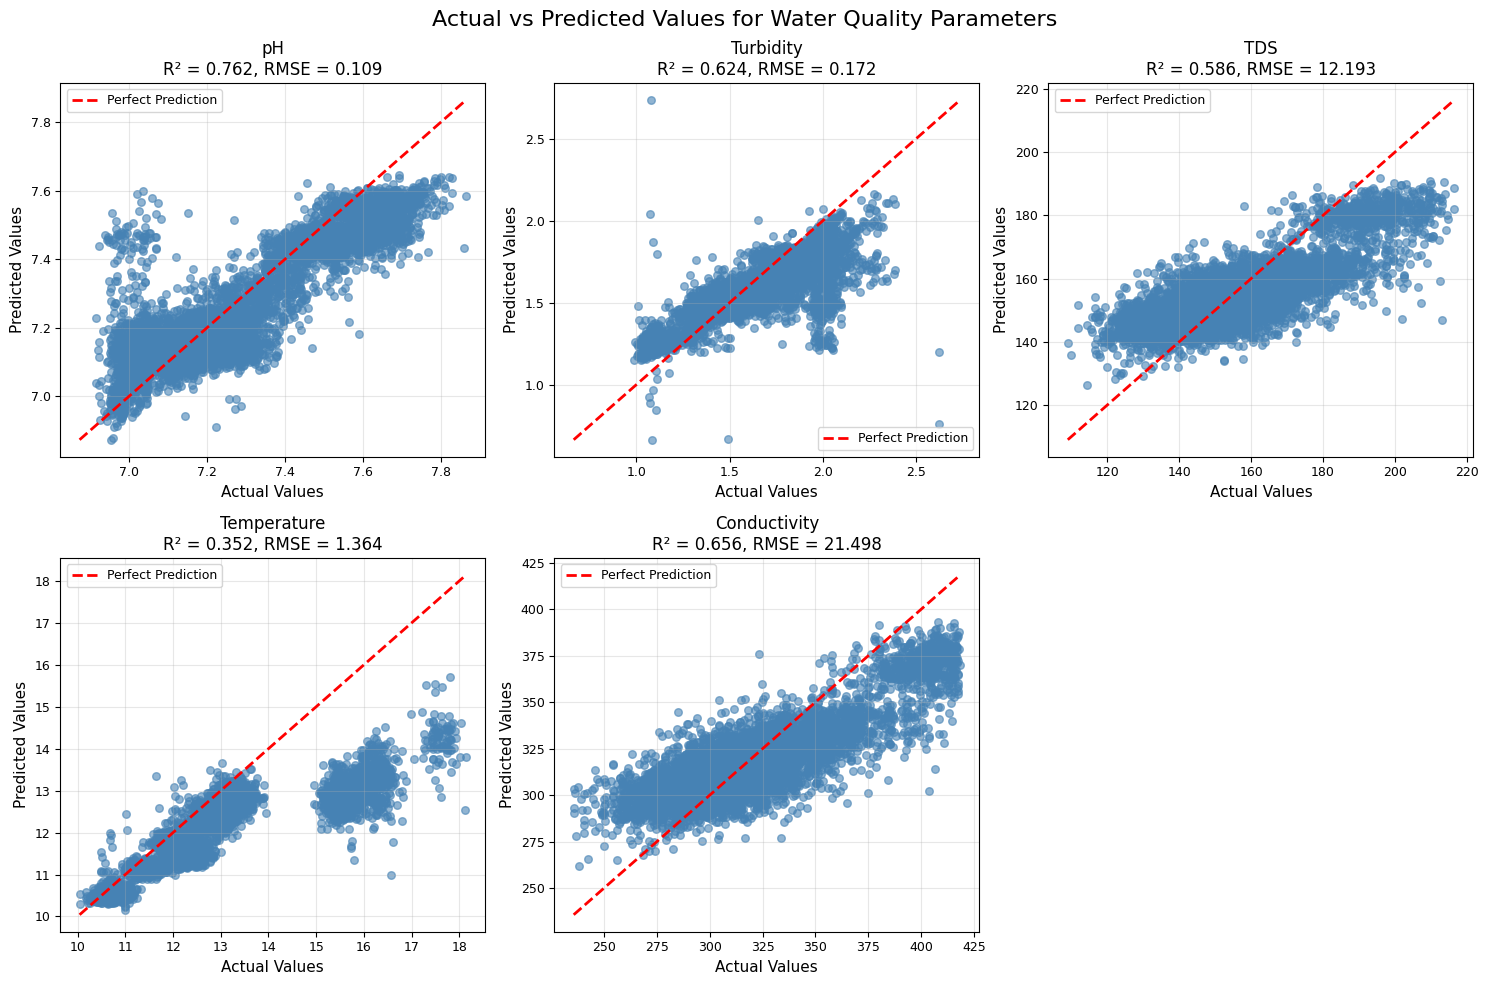

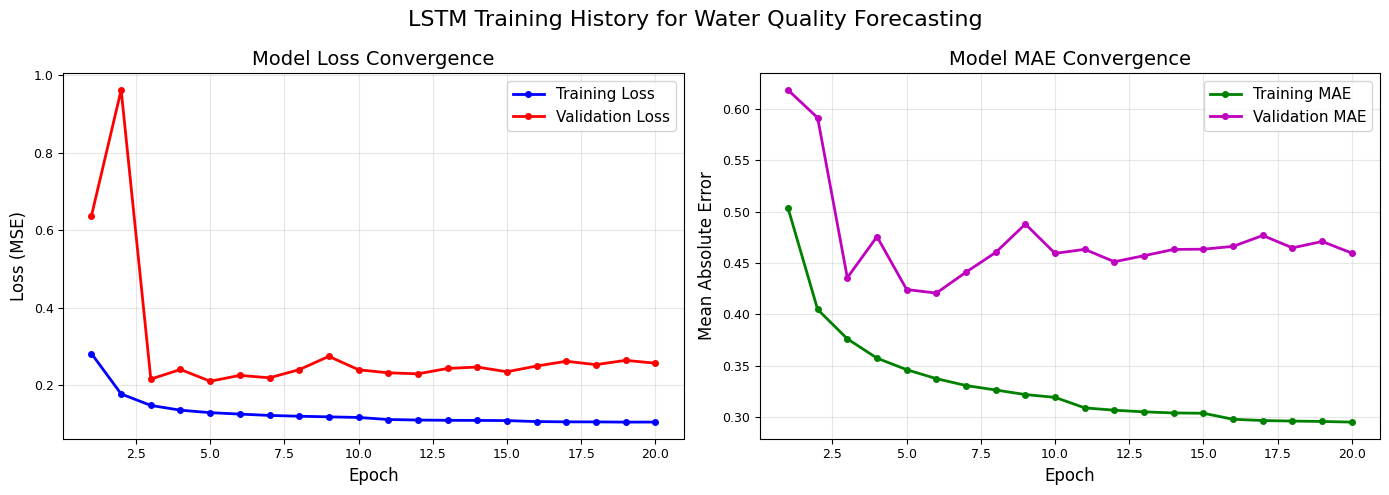

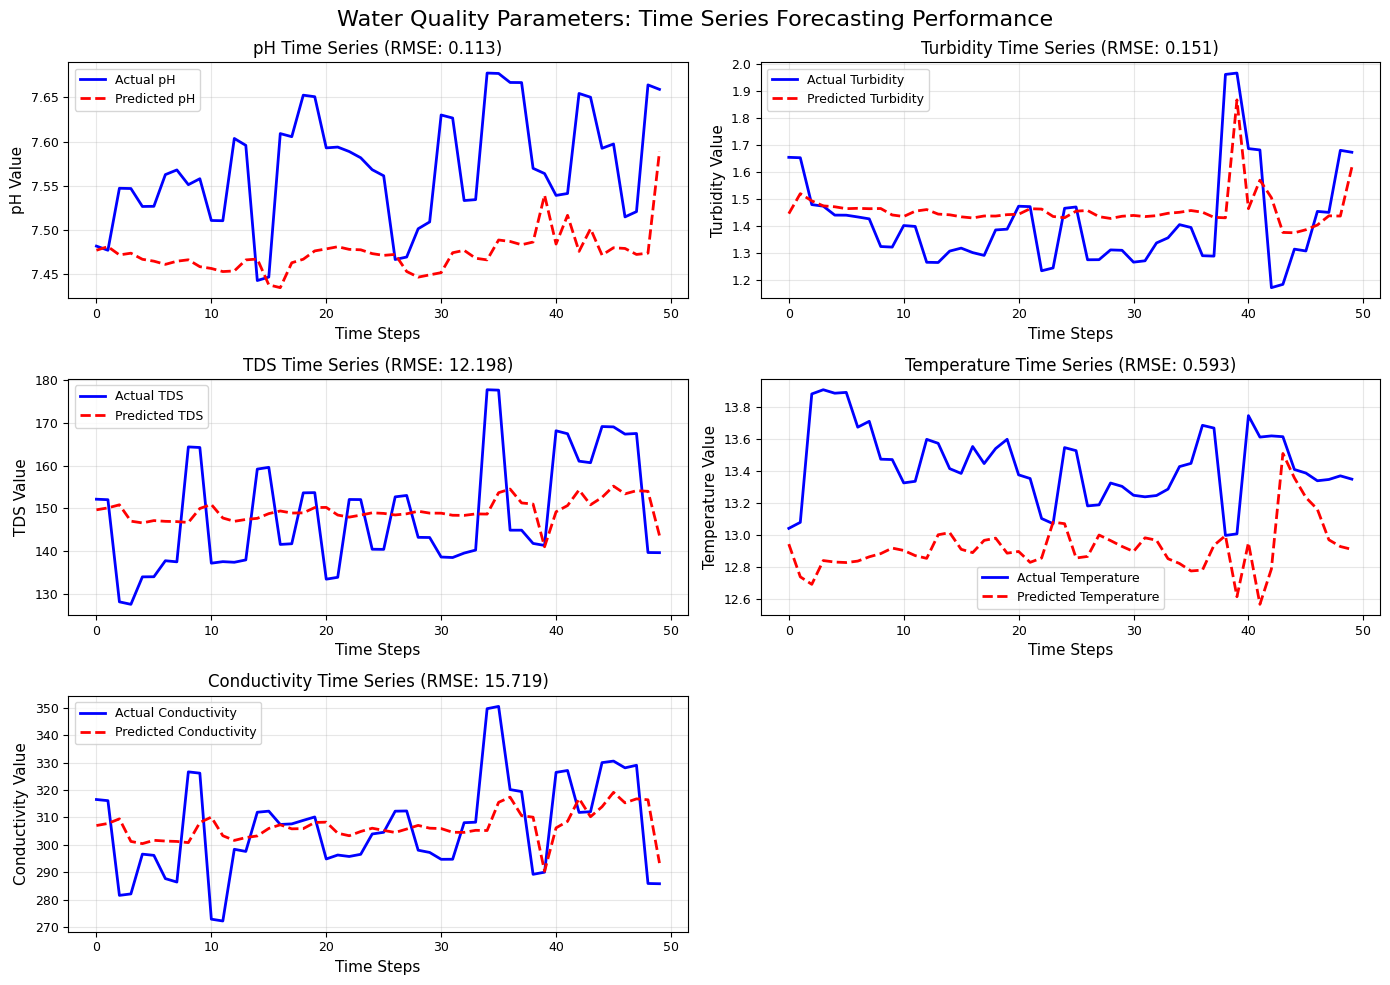

Individual high-quality plots saved:
1. feature_performance_water_quality.png
2. actual_vs_predicted_water_quality.png
3. training_history_water_quality.png
4. time_series_forecasting_water_quality.png

=== FINAL SUMMARY FOR RESEARCH PAPER ===
Water Quality LSTM Forecasting Model Performance Summary:
• Overall R² Score: 0.5962 (Poor performance)
• Overall RMSE: 11.0703
• Overall MAE: 5.5355
• Overall MAPE: 5.25%
• Cross-validation R²: 0.5501 (±0.0943)
• Test samples: 6638
• Sequence length: 15 timesteps
• Features predicted: 5 water quality parameters


In [ ]:
# Create individual high-quality plots for research paper

# 1. Feature-wise Performance Comparison
plt.figure(figsize=(12, 8))

x = np.arange(len(feature_names))
width = 0.35

rmse_values = [metric['RMSE'] for metric in feature_metrics]
r2_values = [metric['R²'] for metric in feature_metrics]

fig, ax1 = plt.subplots(figsize=(12, 6))

# RMSE bars
bars1 = ax1.bar(x - width/2, rmse_values, width, label='RMSE', color='lightcoral', alpha=0.8)
ax1.set_xlabel('Water Quality Parameters', fontsize=14)
ax1.set_ylabel('RMSE', fontsize=14, color='red')
ax1.tick_params(axis='y', labelcolor='red')
ax1.set_xticks(x)
ax1.set_xticklabels(feature_names)

# R² line plot on secondary axis
ax2 = ax1.twinx()
line = ax2.plot(x, r2_values, 'bo-', linewidth=3, markersize=8, label='R² Score')
ax2.set_ylabel('R² Score', fontsize=14, color='blue')
ax2.tick_params(axis='y', labelcolor='blue')
ax2.set_ylim(0, 1)

# Add value labels
for bar, rmse in zip(bars1, rmse_values):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{rmse:.3f}', ha='center', va='bottom', fontsize=10)

for i, r2 in enumerate(r2_values):
    ax2.text(i, r2 + 0.02, f'{r2:.3f}', ha='center', va='bottom', fontsize=10, color='blue')

plt.title('Water Quality LSTM Model: Feature-wise Performance', fontsize=16, pad=20)
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/feature_performance_water_quality.png',
            dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

# 2. Actual vs Predicted Scatter Plot Matrix
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, feature_name in enumerate(feature_names):
    ax = axes[i]
    y_true_feature = y_test_original[:, i]
    y_pred_feature = y_pred_original[:, i]

    # Scatter plot
    ax.scatter(y_true_feature, y_pred_feature, alpha=0.6, s=30, color='steelblue')

    # Perfect prediction line
    min_val = min(y_true_feature.min(), y_pred_feature.min())
    max_val = max(y_true_feature.max(), y_pred_feature.max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')

    # Calculate and display metrics
    r2 = r2_score(y_true_feature, y_pred_feature)
    rmse = np.sqrt(mean_squared_error(y_true_feature, y_pred_feature))

    ax.set_title(f'{feature_name}\nR² = {r2:.3f}, RMSE = {rmse:.3f}', fontsize=12)
    ax.set_xlabel('Actual Values', fontsize=11)
    ax.set_ylabel('Predicted Values', fontsize=11)
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=9)

# Remove the extra subplot
axes[5].remove()

plt.suptitle('Actual vs Predicted Values for Water Quality Parameters', fontsize=16)
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/actual_vs_predicted_water_quality.png',
            dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

# 3. Training History and Model Convergence
plt.figure(figsize=(14, 5))

# Loss subplot
plt.subplot(1, 2, 1)
epochs = range(1, len(history.history['loss']) + 1)
plt.plot(epochs, history.history['loss'], 'bo-', label='Training Loss', linewidth=2, markersize=4)
plt.plot(epochs, history.history['val_loss'], 'ro-', label='Validation Loss', linewidth=2, markersize=4)
plt.title('Model Loss Convergence', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss (MSE)', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

# MAE subplot
plt.subplot(1, 2, 2)
plt.plot(epochs, history.history['mae'], 'go-', label='Training MAE', linewidth=2, markersize=4)
plt.plot(epochs, history.history['val_mae'], 'mo-', label='Validation MAE', linewidth=2, markersize=4)
plt.title('Model MAE Convergence', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Mean Absolute Error', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

plt.suptitle('LSTM Training History for Water Quality Forecasting', fontsize=16)
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/training_history_water_quality.png',
            dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

# 4. Time Series Forecasting Visualization
plt.figure(figsize=(14, 10))

# Show forecasting for multiple features
sample_length = min(50, len(y_test_original))
time_steps = range(sample_length)

for i, feature_name in enumerate(feature_names):
    plt.subplot(3, 2, i+1)
    plt.plot(time_steps, y_test_original[:sample_length, i], 'b-',
             label=f'Actual {feature_name}', linewidth=2)
    plt.plot(time_steps, y_pred_original[:sample_length, i], 'r--',
             label=f'Predicted {feature_name}', linewidth=2)

    # Calculate and display RMSE for this segment
    rmse = np.sqrt(mean_squared_error(y_test_original[:sample_length, i],
                                     y_pred_original[:sample_length, i]))
    plt.title(f'{feature_name} Time Series (RMSE: {rmse:.3f})', fontsize=12)
    plt.xlabel('Time Steps', fontsize=11)
    plt.ylabel(f'{feature_name} Value', fontsize=11)
    plt.legend(fontsize=9)
    plt.grid(True, alpha=0.3)

plt.suptitle('Water Quality Parameters: Time Series Forecasting Performance', fontsize=16)
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/time_series_forecasting_water_quality.png',
            dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print("Individual high-quality plots saved:")
print("1. feature_performance_water_quality.png")
print("2. actual_vs_predicted_water_quality.png")
print("3. training_history_water_quality.png")
print("4. time_series_forecasting_water_quality.png")

# Create summary table for research paper
print("\n=== FINAL SUMMARY FOR RESEARCH PAPER ===")
print(f"Water Quality LSTM Forecasting Model Performance Summary:")
print(f"• Overall R² Score: {overall_r2:.4f} ({performance} performance)")
print(f"• Overall RMSE: {overall_rmse:.4f}")
print(f"• Overall MAE: {overall_mae:.4f}")
print(f"• Overall MAPE: {overall_mape:.2f}%")
print(f"• Cross-validation R²: {cv_r2_mean:.4f} (±{np.std(cv_scores['r2']):.4f})")
print(f"• Test samples: {len(y_test_original)}")
print(f"• Sequence length: {sequence_length} timesteps")
print(f"• Features predicted: {len(feature_names)} water quality parameters")